In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
# imported libraries

In [23]:
# #clean per-capita-meat-type.csv
# import pandas as pd

# meat_df = pd.read_csv("datasets/original datasets/per-capita-meat-type.csv")
# codes_df = pd.read_csv("datasets/codes.csv")

# merged = pd.merge(meat_df, codes_df, left_on="Code", right_on="alpha-3", how="left")

# filtered = merged[merged["region"].isin(["Asia", "Europe"])]

# latest = filtered.sort_values("Year").groupby("Code").tail(1)

# meat_columns = [col for col in latest.columns if col.startswith("Meat")]
# latest["Total_Meat_kg_per_capita"] = latest[meat_columns].sum(axis=1)

# final_df = latest[["Entity", "Code", "Year", "region", "Total_Meat_kg_per_capita"] + meat_columns]

# final_df.to_csv("asia_europe_meat_consumption.csv", index=False)

# print(final_df["region"].value_counts())


In [24]:
# What we are going to do is use bootstrap sampling on the correlation between meat consumption and michlein star count.
# The rationale here is as such:
# Each COUNTRY has two VALUES. These VALUES are MEAT CONSUMPTION and MICHELIN COUNT (this can be either count of restaurants or count of stars.)
# We divide the two groups of countries into ASIAN and EUROPEAN.

# Why our research is relevant
---
There is always the debate in diet of meats versus vegetables, and we want to find out if they really are mutually exclusive. We also want to analyse the trends in meat and vegetable consumption over the years, and how they play off of each other.

In [3]:
# Import relevant datasets

df_meats = pd.read_csv('datasets/per-capita-meat-type.csv')
df_vegs = pd.read_csv('datasets/vegetable-consumption-per-capita.csv')

# Replace long column names with ones that are more easy to access
df_meats = df_meats.rename(columns={
    'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'Poultry',
    'Meat, beef and buffalo | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita': 'BeefBuffalo',
    'Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita': 'SheepGoat',
    'Meat, pig | 00002733 || Food available for consumption | 0645pc || kilograms per year per capita': 'Pig',
    'Meat, Other | 00002735 || Food available for consumption | 0645pc || kilograms per year per capita': 'OtherMeat',
    'Fish and seafood | 00002960 || Food available for consumption | 0645pc || kilograms per year per capita': 'Seafood'
})

# Find total consumption
df_meats['totalconsumption'] = df_meats[['Poultry', 'BeefBuffalo', 'SheepGoat', 'Pig', 'OtherMeat', 'Seafood']].sum(axis=1, skipna=True)

df_vegs = df_vegs.rename(columns={
    'Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita': 'Vegetables'
})

# Compensate for muslim countries which may not have info for pigs.
df_meats['Pig'] = df_meats['Pig'].fillna(0)

print(df_meats.head())
print(df_vegs.head())

        Entity Code  Year   Poultry  BeefBuffalo  SheepGoat  Pig  OtherMeat  \
0  Afghanistan  AFG  1961  0.612220     4.664536   7.949147  0.0   0.826012   
1  Afghanistan  AFG  1962  0.641587     4.870231   7.699047  0.0   0.855450   
2  Afghanistan  AFG  1963  0.641828     4.920679   7.867252  0.0   1.040539   
3  Afghanistan  AFG  1964  0.651754     4.893021   8.122609  0.0   0.982495   
4  Afghanistan  AFG  1965  0.681102     4.855283   8.406744  0.0   1.031383   

    Seafood  totalconsumption  
0  0.029153         14.081069  
1  0.029163         14.095478  
2  0.029174         14.499472  
3  0.029183         14.679062  
4  0.029190         15.003702  
        Entity Code  Year  Vegetables
0  Afghanistan  AFG  1961   35.712856
1  Afghanistan  AFG  1962   36.424660
2  Afghanistan  AFG  1963   37.799760
3  Afghanistan  AFG  1964   39.076070
4  Afghanistan  AFG  1965   39.727703


In [4]:
# EDA
# What is the data we will need to be able to effectively answer the Q?
# Filter by current data. Get some summary statistics.
# Get histogram of meat and veg in 2022/2024.
# Get ECDF of meat and veg in 2022/2024.

# --------------------------------- Histogram -------------------------------- #
# For meat
# For all countries, so we should filter by entries that have a code.

# Calculate total meat

# Keep only rows for year 2022
meat_2022 = df_meats[df_meats['Year'] == 2022]

# Create a code filter for european countries
eu_codes = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA',
    'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE',
    'ALB', 'AND', 'ARM', 'BLR', 'BIH', 'FRO', 'GEO', 'GIB', 'ISL', 'IMN', 'XKX', 'LIE', 'MKD', 'MDA', 'MCO',
    'MNE', 'NOR', 'RUS', 'SMR', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'VAT'
]


# Create a code filter for asian countries
ap_codes = [
    'AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'IOT', 'BRN',
    'KHM', 'CHN', 'CCK', 'GEO', 'HKG', 'IND', 'IDN', 'IRN',
    'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO',
    'LBN', 'MAC', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'PRK',
    'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU', 'SGP', 'KOR',
    'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TUR', 'TKM', 'ARE',
    'UZB', 'VNM', 'YEM'
]

# Filter
meat_2022_eu = meat_2022[meat_2022['Code'].isin(eu_codes)]
meat_2022_ap = meat_2022[meat_2022['Code'].isin(ap_codes)]

# Do the same for vegetables
veg_2022 = df_vegs[df_vegs['Year'] == 2022]

veg_2022_eu = veg_2022[veg_2022['Code'].isin(eu_codes)]
veg_2022_ap = veg_2022[veg_2022['Code'].isin(ap_codes)]

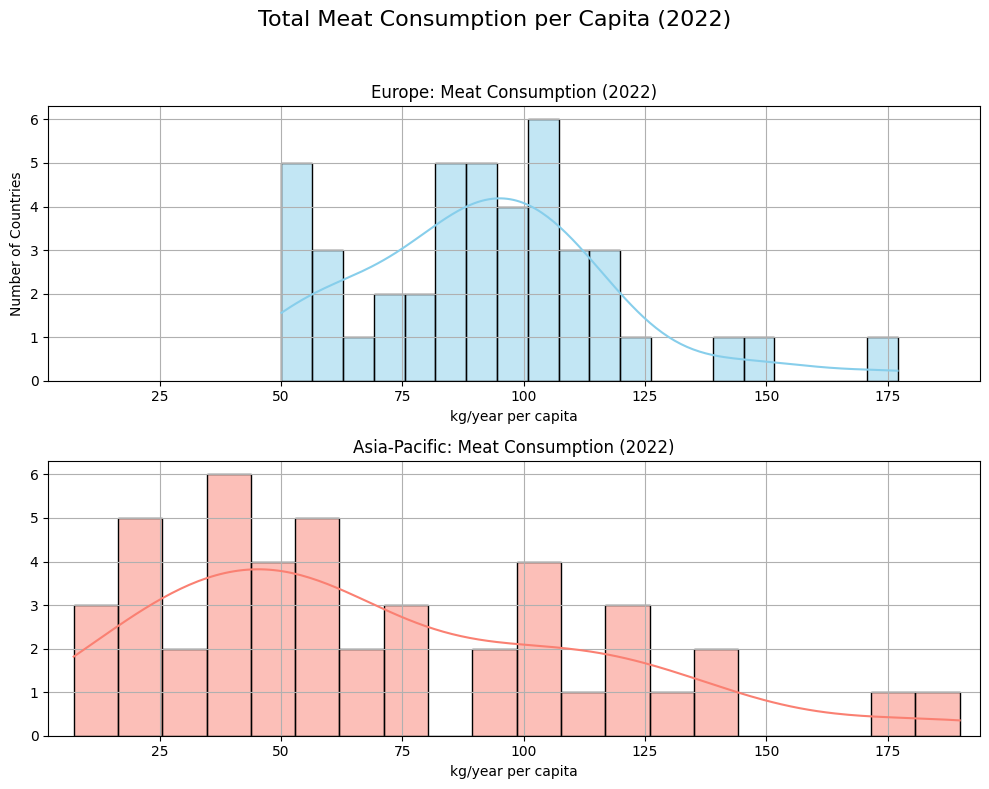

c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


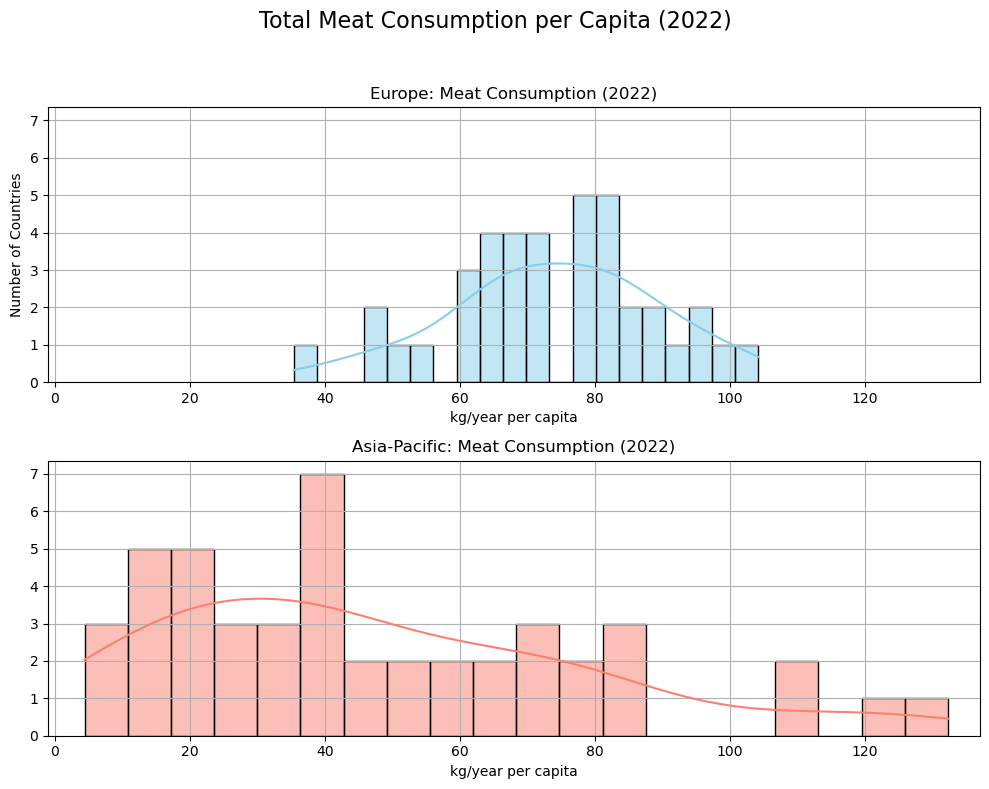

c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jingk\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


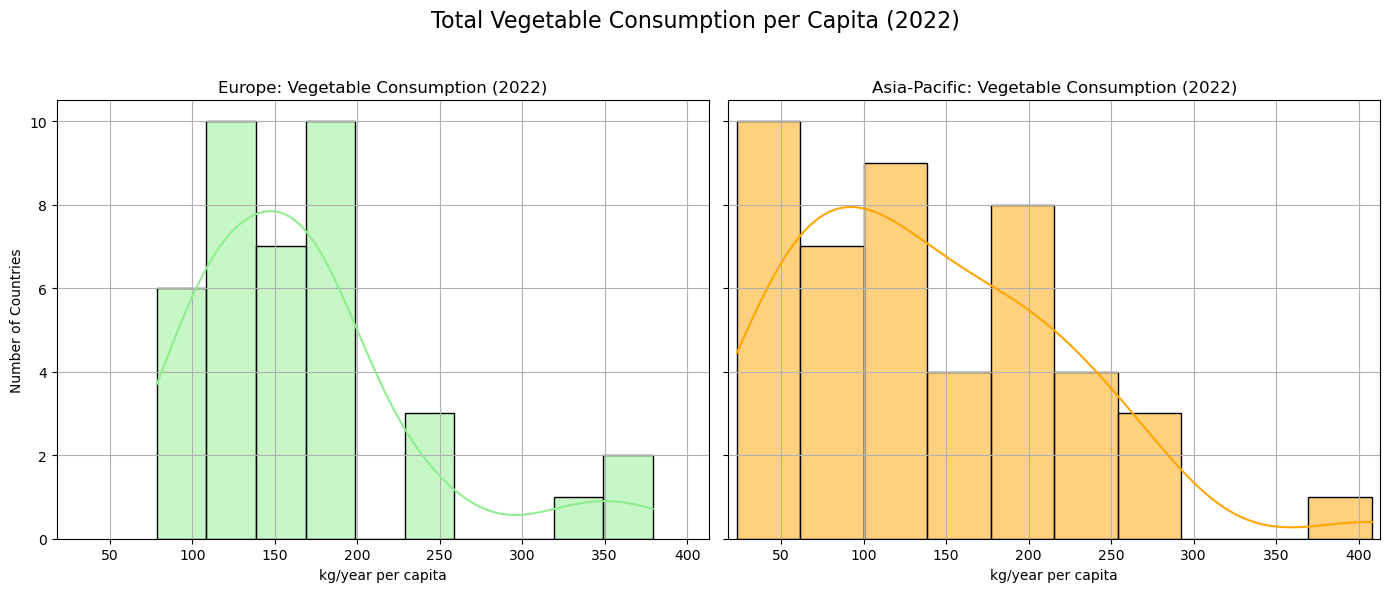

In [ ]:
#This is the refactored code for Tuns eda, it uses merged_meat_fruit_veg.csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LOAAAAAAAAAADDDDDDDDDDDDDDDDD
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Filter data for twozerotwotwo
merged_2022 = merged_df[merged_df['Year'] == 2022]

# seperate data by region
europe_data = merged_2022[merged_2022['region'] == 'Europe']
asia_data = merged_2022[merged_2022['region'] == 'Asia']

#  Meat Consumption Histogram  #
# Get combined min and max for x-axis
min_x_meat = min(europe_data['Total_Meat_kg_per_capita'].min(), asia_data['Total_Meat_kg_per_capita'].min())
max_x_meat = max(europe_data['Total_Meat_kg_per_capita'].max(), asia_data['Total_Meat_kg_per_capita'].max())
xlim_meat = (int(min_x_meat) - 5, int(max_x_meat) + 5)

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(europe_data['Total_Meat_kg_per_capita'], color='skyblue', kde=True, bins=20, ax=axs[0])
axs[0].set_title('Europe: Meat Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_meat)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Total_Meat_kg_per_capita'], color='salmon', kde=True, bins=20, ax=axs[1])
axs[1].set_title('Asia-Pacific: Meat Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_meat)
axs[1].grid(True)

fig.suptitle('Total Meat Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Vegetable Consumption Histogram  #
# Get combined min and max for x-axis
min_x_veg = min(europe_data['Vegetables_kg_per_capita'].min(), asia_data['Vegetables_kg_per_capita'].min())
max_x_veg = max(europe_data['Vegetables_kg_per_capita'].max(), asia_data['Vegetables_kg_per_capita'].max())
xlim_veg = (int(min_x_veg) - 5, int(max_x_veg) + 5)

# Set up side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Europe histogram
sns.histplot(europe_data['Vegetables_kg_per_capita'], color='lightgreen', kde=True, bins=10, ax=axs[0])
axs[0].set_title('Europe: Vegetable Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_veg)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Vegetables_kg_per_capita'], color='orange', kde=True, bins=10, ax=axs[1])
axs[1].set_title('Asia-Pacific: Vegetable Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_veg)
axs[1].grid(True)


fig.suptitle('Total Vegetable Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
#This is what i used to merge the datasets, not rlly needed anymore but here it is for reference
# import pandas as pd

# # Load datasets
# meat_df = pd.read_csv("datasets/asia_europe_meat_consumption.csv")
# fruit_df = pd.read_csv("datasets/fruit-consumption-per-capita.csv")
# veg_df = pd.read_csv("datasets/vegetable-consumption-per-capita.csv")

# # Rename columns for clarity
# fruit_df = fruit_df.rename(columns={
#     "Fruit | 00002919 || Food available for consumption | 0645pc || kilograms per year per capita": "Fruit_kg_per_capita"
# })
# veg_df = veg_df.rename(columns={
#     "Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita": "Vegetables_kg_per_capita"
# })

# # Merge datasets on Entity, Code, and Year
# merged_df = meat_df.merge(
#     fruit_df[["Entity", "Code", "Year", "Fruit_kg_per_capita"]],
#     on=["Entity", "Code", "Year"],
#     how="inner"
# ).merge(
#     veg_df[["Entity", "Code", "Year", "Vegetables_kg_per_capita"]],
#     on=["Entity", "Code", "Year"],
#     how="inner"
# )

# # Check for missing values
# print(merged_df.isnull().sum())

# # Save the merged dataset
# merged_df.to_csv("datasets/merged_meat_fruit_veg.csv", index=False)

# # Display the first few rows of the merged dataset
# print(merged_df.head())

Entity                                                                                                           0
Code                                                                                                             0
Year                                                                                                             0
region                                                                                                           0
Total_Meat_kg_per_capita                                                                                         0
Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita             0
Meat, beef and buffalo | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita    0
Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita      0
Meat, pig | 00002733 || Food available for consumption | 0645pc || kilograms per